In [2]:
import pandas as pd
import numpy as np
import os
import geopandas as gpd
import sys
import pathlib
import glob
import matplotlib.pyplot as plt
from urllib.parse import quote
from sqlalchemy import create_engine
import configparser


import statsmodels.api as sm
#import pingouin as pg
import plotly.express as px

In [3]:
sys.path.append("../../Micromet")
import micromet
from micromet import AmerifluxDataProcessor
from micromet import thermal_diffusivity_amplitude, thermal_diffusivity_lag, volumetric_heat_capacity, thermal_conductivity, diurnal_amplitude, diurnal_peak_lag, soil_heat_flux,calculate_thermal_diffusivity_for_all_pairs
%matplotlib inline

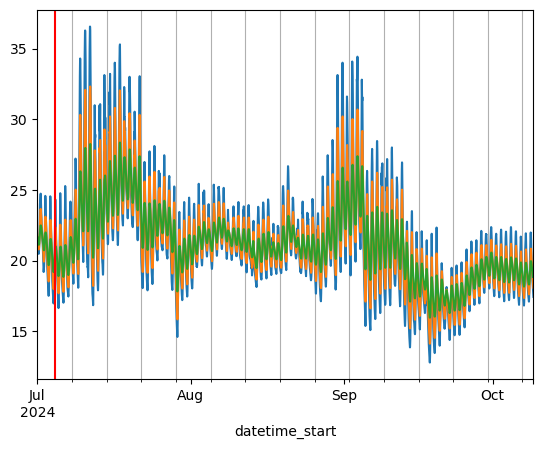

In [4]:
soildfs = pd.read_parquet('../station_data/all_soil_data.parquet')
utd_soilt = soildfs.loc['US-UTD'][['ts_3_1_1','ts_3_2_1','ts_3_3_1','swc_3_1_1','swc_3_2_1','swc_3_3_1']].replace(-9999,np.nan)
utd_soilt = utd_soilt[utd_soilt.index >= '2024-07-01']#.resample('30T').mean()
utd_soilt['ts_3_1_1'].plot()
utd_soilt['ts_3_2_1'].shift(-1).plot()
utd_soilt['ts_3_3_1'].shift(-5).plot()
plt.axvline('2024-07-04 15:00',color='r')
#plt.xlim('2024-07-01','2024-07-08')
#plt.ylim(10,35)
plt.grid(True, which='minor')

In [6]:
utd_soilt = soildfs.loc['US-UTD'][['ts_3_1_1','ts_3_2_1','ts_3_3_1','swc_3_1_1','swc_3_2_1','swc_3_3_1']].replace(-9999,np.nan)
utd_soilt = utd_soilt[utd_soilt.index >= '2024-07-01']#.resample('30T').mean()
utd_soilt.to_parquet('utd_soil_data.parquet')
utd_soilt.to_csv('utd_soil_data.csv')

In [ ]:
z1 = 0.05
z2 = 0.10
z3 = 0.15

series1 = utd_soilt['ts_3_1_1']
series2 = utd_soilt['ts_3_2_1']
series3 = utd_soilt['ts_3_3_1']

# Calculate diurnal amplitude
amp1 = diurnal_amplitude(series1)
amp2 = diurnal_amplitude(series2)
amp3 = diurnal_amplitude(series3)

# Calculate diurnal peak lag
#lag1 = diurnal_peak_lag(series1, series2)
lag_shallow = diurnal_peak_lag(series2, series1)
lag_deep = diurnal_peak_lag(series3, series1)

# Calculate α from amplitude
alpha_amp_shallow = thermal_diffusivity_amplitude(amp1, amp2, z1, z2)
alpha_amp_deep = thermal_diffusivity_amplitude(amp1, amp3, z1, z3)
print(f"Thermal diffusivity shallow (amplitude): {alpha_amp_shallow.median():.2e} m²/s")
print(f"Thermal diffusivity deep (amplitude): {alpha_amp_deep.median():.2e} m²/s")

# Calculate α from lag
alpha_lag_shallow = thermal_diffusivity_lag(lag_shallow*3600, z1, z2)
alpha_lag_deep = thermal_diffusivity_lag(lag_deep*3600, z1, z3)
print(f"Thermal diffusivity shallow (lag): {alpha_lag_shallow.median():.2e} m²/s")
print(f"Thermal diffusivity deep (lag): {alpha_lag_deep.median():.2e} m²/s")


# Define the mapping of column names to depths
depth_mapping = {'ts_3_1_1': 0.05, 'ts_3_2_1': 0.1, 'ts_3_3_1': 0.2, 'ts_3_4_1': 0.3, 'ts_3_5_1': 0.4, 'ts_3_6_1': 0.5} 

# Calculate thermal diffusivity for all possible pairs of depths
all_diff_log = calculate_thermal_diffusivity_for_all_pairs(utd_soilt, depth_mapping)
print("\nThermal diffusivities for all depth pairs:")
print(all_diff_log)

all_diff_lag = calculate_thermal_diffusivity_lag_for_all_pairs(utd_soilt, depth_mapping)

# Volumnetric heat capacity
Cv = volumetric_heat_capacity(utd_soilt[['swc_3_1_1','swc_3_2_1']].mean(axis=1)/100).resample('D').mean()

# Estimate k (using average of both α estimates)

k_amp_s = thermal_conductivity(alpha_amp_shallow, Cv).replace([np.inf, -np.inf], np.nan).mean()
k_amp_d = thermal_conductivity(alpha_amp_deep, Cv).replace([np.inf, -np.inf], np.nan).mean()
k_lag_s = thermal_conductivity(alpha_lag_shallow, Cv).replace([np.inf, -np.inf], np.nan).mean()
k_lag_d = thermal_conductivity(alpha_lag_deep, Cv).replace([np.inf, -np.inf], np.nan).mean()
#k_avg = thermal_conductivity(alpha_avg, Cv).replace([np.inf, -np.inf], np.nan).mean()


clr = ['r','g','b']
i = 0

ks = [k_amp, k_lag, k_avg]
#ks = [k_lag]

for k in ks:
    print(f"Thermal conductivity: {k.mean():.4f} W/m/K")
    g = soil_heat_flux(utd_soilt['ts_3_1_1'], utd_soilt['ts_3_2_1'], z1, z2, k)
    g.plot(color=clr[i])
    print(g.mean())
    i += 1

plt.grid(True, which='minor')
plt.legend(['Amplitude','Lag','Average'])
plt.ylabel('G W/m2')

Thermal diffusivity shallow (amplitude): 6.21e-07 m²/s
Thermal diffusivity deep (amplitude): 3.19e-07 m²/s
Thermal diffusivity shallow (lag): 1.33e-06 m²/s
Thermal diffusivity deep (lag): 5.89e-07 m²/s

Thermal diffusivities for all depth pairs:
  depth1_col depth2_col  z1 (m)  z2 (m)  thermal_diffusivity (m^2/s)
0   ts_3_1_1   ts_3_2_1    0.05     0.1                 5.504777e-07
1   ts_3_1_1   ts_3_3_1    0.05     0.2                 4.503450e-07
2   ts_3_2_1   ts_3_3_1    0.10     0.2                 2.976171e-07


NameError: name 'k_amp' is not defined

In [ ]:
alpha_lag

In [ ]:
cdf = pd.read_parquet('../station_data/all_eddy_data.parquet')
cdf.loc['US-UTD',:].loc['2024-07-01':'2024-10-08','g'].replace(-9999,np.nan).plot()

In [ ]:
cdf